In [50]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ast
import math
import os


read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


In [6]:
df = pd.read_csv('./q4_data/CSV/TLBR_159.csv')
print(df)


     Unnamed: 0      Top-Left  Bottom-Right   Id
0             0    [365, 291]    [783, 362]    0
1             1    [802, 284]    [858, 342]    1
2             2    [873, 291]    [931, 345]    2
3             3   [1972, 280]   [2062, 335]    3
4             4    [363, 455]    [464, 520]    4
..          ...           ...           ...  ...
124         124   [355, 3104]   [706, 3179]  124
125         125   [728, 3090]  [1201, 3162]  125
126         126  [1221, 3093]  [1259, 3148]  126
127         127  [1279, 3090]  [1465, 3155]  127
128         128  [1489, 3097]  [1723, 3158]  128

[129 rows x 4 columns]


In [7]:
img = cv2.imread('./q4_data/images/159.jpg')

Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [8]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    # print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(img_2)

In [9]:
def make_connections(image,euclidean):
  
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      # print(row)
      
      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

        # drawing rectangle arounf the sample
      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

        # placing the label(with box id) on the corresponding box
      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        
      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])

      # print(top_adjacent_id)
      
      if top_adjacent_id != 0:
          # print(euclidean[(euclidean['Id'] == top_adjacent_id)])
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

True

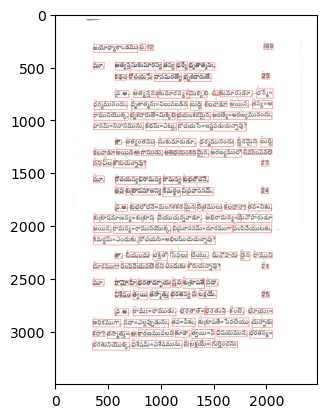

In [48]:
new_image = make_connections(img,euclid_df)
plt.imshow(new_image)
cv2.imwrite('connected_image.png',new_image)

In [ ]:
# visualize_bboxes(img)

In [11]:
def convert_string_to_list(string):
    # Remove brackets and split by comma
    values = string.strip('[]').split(',')
    
    # Convert values to integers
    try:
        a = int(values[0])
        b = int(values[1])
        return [a, b]
    except (ValueError, IndexError):
        return None  # Handle conversion errors or invalid input


In [27]:
def calcDistance(point1,point2):
    euclidean_distance = math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return euclidean_distance

In [45]:
def convert_dataframe(df):
    n = len(df)
    euclid_df = pd.DataFrame()  # Create an empty DataFrame
    
    # Extract and convert 'Id' column
    euclid_df['Id'] = df['Id']
    
    # Define a function to convert the string columns to lists of integers
    def convert_string_to_list(string):
        # Remove brackets and split by comma
        values = string.strip('[]').split(',')
        
        # Convert values to integers
        try:
            l = int(values[0])
            t = int(values[1])
            return [l, t]
        except (ValueError, IndexError):
            return None  # Handle conversion errors or invalid input
    
    # Apply the conversion function to 'Top-Left' and 'Bottom-Right' columns
    a = df['Top-Left'].apply(convert_string_to_list)
    A = np.array(a.tolist())
    l = A[:,0]
    t = A[:,1]

    a = df['Bottom-Right'].apply(convert_string_to_list)
    A = np.array(a.tolist())
    r = A[:,0]
    b=  A[:,1]

    left = np.column_stack((l,(t+b)/2))
    right = np.column_stack((r,(t+b)/2))
    top = np.column_stack(((l+r)/2,t))
    bottom = np.column_stack(((l+r)/2,b))
    
    # print(left.tolist())
    
    euclid_df['Left'] = left.tolist()
    euclid_df['Right'] = right.tolist()
    euclid_df['Top'] = top.tolist()
    euclid_df['Bottom'] = bottom.tolist()
    
    
    euclid_df['Top_Box'] = None
    euclid_df['Bottom_Box'] = None
    euclid_df['Left_Box'] = None
    euclid_df['Right_Box'] = None
    
    e = 75
    
    lb = np.array([])
    rb = np.array([])
    tb = np.array([])
    bb = np.array([])
    
    
    for i1,r1 in euclid_df.iterrows():
        min_id = 0
        min_dist = 10000000
        for i2,r2 in euclid_df.iterrows():
            if(r1['Id']!=r2['Id']):
                dst = calcDistance(r2['Right'],r1['Left'])
                d1 = calcDistance(r1['Top'],r2['Top'])
                d2 = calcDistance(r1['Bottom'],r2['Bottom'])
                if(dst<=e and dst<=min_dist):
                    min_dist = dst
                    min_id = r2['Id']
            # else:
            #     print('i1 = ',i1,' i2 = ',i2)
        if min_dist==10000000:
            min_dist=-1
        lb = np.append(lb,[min_dist,min_id])
    lb = lb.reshape(n,2)
    euclid_df['Left_Box'] = lb.tolist()
    
    for i1,r1 in euclid_df.iterrows():
        min_id = 0
        min_dist = 10000000
        for i2,r2 in euclid_df.iterrows():
            if(r1['Id']!=r2['Id']):
                dst = calcDistance(r2['Left'],r1['Right'])
                d1 = calcDistance(r1['Top'],r2['Top'])
                d2 = calcDistance(r1['Bottom'],r2['Bottom'])
                if(dst<=e and dst<=min_dist):
                    min_dist = dst
                    min_id = r2['Id']
            # else:
                # print('i1 = ',i1,' i2 = ',i2)
        if min_dist==10000000:
            min_dist=-1
        rb = np.append(rb,[min_dist,min_id])
    rb = rb.reshape(n,2)
    euclid_df['Right_Box'] = rb.tolist()
    
    for i1,r1 in euclid_df.iterrows():
        min_id = 0
        min_dist = 10000000
        for i2,r2 in euclid_df.iterrows():
            if(r1['Id']!=r2['Id']):
                dst = calcDistance(r2['Bottom'],r1['Top'])
                d1 = calcDistance(r1['Right'],r2['Right'])
                d2 = calcDistance(r1['Left'],r2['Left'])
                if(dst<=e and dst<=min_dist):
                    min_dist = dst
                    min_id = r2['Id']
            # else:
                # print('i1 = ',i1,' i2 = ',i2)
        if min_dist==10000000:
            min_dist=-1
        tb = np.append(tb,[min_dist,min_id])
    tb = tb.reshape(n,2)
    euclid_df['Top_Box'] = tb.tolist()

    for i1,r1 in euclid_df.iterrows():
        min_id = 0
        min_dist = 10000000
        for i2,r2 in euclid_df.iterrows():
            if(r1['Id']!=r2['Id']):
                dst = calcDistance(r2['Top'],r1['Bottom'])
                d1 = calcDistance(r1['Right'],r2['Right'])
                d2 = calcDistance(r1['Left'],r2['Left'])
                if(dst<=e and dst<=min_dist):
                    min_dist = dst
                    min_id = r2['Id']
            # else:
                # print('i1 = ',i1,' i2 = ',i2)
        if min_dist==10000000:
            min_dist=-1
        bb = np.append(bb,[min_dist,min_id])
    bb = bb.reshape(n,2)
    euclid_df['Bottom_Box'] = bb.tolist()

    
    
    return euclid_df



In [46]:
print(df)

     Unnamed: 0      Top-Left  Bottom-Right   Id
0             0    [365, 291]    [783, 362]    0
1             1    [802, 284]    [858, 342]    1
2             2    [873, 291]    [931, 345]    2
3             3   [1972, 280]   [2062, 335]    3
4             4    [363, 455]    [464, 520]    4
..          ...           ...           ...  ...
124         124   [355, 3104]   [706, 3179]  124
125         125   [728, 3090]  [1201, 3162]  125
126         126  [1221, 3093]  [1259, 3148]  126
127         127  [1279, 3090]  [1465, 3155]  127
128         128  [1489, 3097]  [1723, 3158]  128

[129 rows x 4 columns]


In [47]:
df = pd.read_csv('./q4_data/CSV/TLBR_159.csv')
euclid_df = convert_dataframe(df)
print(euclid_df)

      Id              Left             Right               Top  \
0      0    [365.0, 326.5]    [783.0, 326.5]    [574.0, 291.0]   
1      1    [802.0, 313.0]    [858.0, 313.0]    [830.0, 284.0]   
2      2    [873.0, 318.0]    [931.0, 318.0]    [902.0, 291.0]   
3      3   [1972.0, 307.5]   [2062.0, 307.5]   [2017.0, 280.0]   
4      4    [363.0, 487.5]    [464.0, 487.5]    [413.5, 455.0]   
..   ...               ...               ...               ...   
124  124   [355.0, 3141.5]   [706.0, 3141.5]   [530.5, 3104.0]   
125  125   [728.0, 3126.0]  [1201.0, 3126.0]   [964.5, 3090.0]   
126  126  [1221.0, 3120.5]  [1259.0, 3120.5]  [1240.0, 3093.0]   
127  127  [1279.0, 3122.5]  [1465.0, 3122.5]  [1372.0, 3090.0]   
128  128  [1489.0, 3127.5]  [1723.0, 3127.5]  [1606.0, 3097.0]   

               Bottom                     Top_Box   Bottom_Box  \
0      [574.0, 362.0]                 [-1.0, 0.0]  [-1.0, 0.0]   
1      [830.0, 342.0]                 [-1.0, 0.0]  [-1.0, 0.0]   
2      [9

In [ ]:
make_connections(img,euclid_df)

In [58]:
def connectImage(img,df,name):
    loc = './q4_output/'+name+'.jpg'
    euclid_df = convert_dataframe(df)
    new_image = make_connections(img,euclid_df)
    plt.imshow(new_image)
    cv2.imwrite(loc,new_image)
    print('Image '+name+' done!')

Image 152 done!
Image 201 done!
Image 232 done!
Image 250 done!
Image 68 done!
Image 174 done!
Image 101 done!
Image 145 done!
Image 159 done!
Image 29 done!


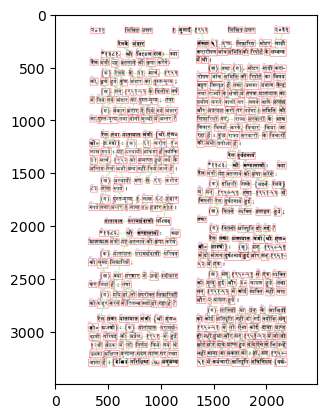

In [62]:
folder_path1 = './q4_data/images/'  # Replace with the path to your folder
folder_path2 = './q4_data/CSV/'

for filename in os.listdir(folder_path1):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        name, _ = os.path.splitext(filename)
        df = pd.read_csv(folder_path2+'TLBR_'+name+'.csv')
        img = cv2.imread(folder_path1+filename)
        connectImage(img,df,name)
        


Image paplu done!


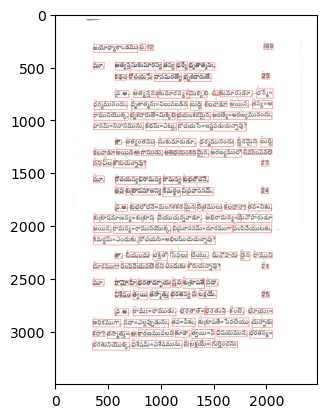

In [59]:
img = cv2.imread('./q4_data/images/159.jpg')
df = pd.read_csv('./q4_data/CSV/TLBR_159.csv')
# euclid_df = convert_dataframe(df)
# print(euclid_df)
connectImage(img,df,'paplu')